### Comparing Custom SHAP Approximator with Original SHAP on Simulated Data

In this notebook, we will:

- Simulate both tabular and sequential data with known true feature importances.
- Train models (XGBoost for tabular data and LSTM for sequential data) on the simulated data.
- Compute SHAP values using both the original SHAP package and a custom SHAP approximator.
- Compare the SHAP values from both methods with each other and with the true feature importances.
- Analyze and visualize the results.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from scipy.stats import pearsonr

from src.simulation import TabularDataSimulator, SequentialDataSimulator
from src.shap_engine import TabularSHAPApproximator, SequentialSHAPApproximator

/home/niyang/miniconda3/envs/shap/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-10-13 14:05:56.923489: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-13 14:05:56.931190: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-13 14:05:56.979125: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-13 14:05:57.064659: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-13 14:0

#### Simulate Tabular Data and Train XGBoost Model


In [2]:
# Simulate tabular data
tabular_simulator = TabularDataSimulator(n_samples=1000, n_features=10)
X, y = tabular_simulator.get_data()
true_importances = tabular_simulator.get_true_importances()

# Convert to NumPy array if necessary
if isinstance(X, pd.DataFrame):
    X = X.values

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Train XGBoost model
model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [3]:
# Compute SHAP values using SHAP package
explainer_shap = shap.TreeExplainer(model_xgb)
shap_values_shap = explainer_shap.shap_values(X_test)

In [4]:
# Initialize custom SHAP approximator
custom_shap_approximator = TabularSHAPApproximator(model_xgb, X_train, num_samples=100)

# Compute SHAP values using custom approximator
shap_values_custom = custom_shap_approximator.compute_shap_values(X_test)


In [5]:
# Compute mean absolute SHAP values
mean_abs_shap_values = np.mean(np.abs(shap_values_shap), axis=0)
mean_abs_custom_shap_values = np.mean(np.abs(shap_values_custom), axis=0)

# Normalize SHAP values
norm_mean_abs_shap_values = mean_abs_shap_values / np.sum(mean_abs_shap_values)
norm_mean_abs_custom_shap_values = mean_abs_custom_shap_values / np.sum(mean_abs_custom_shap_values)

# Create DataFrame for comparison
feature_names = [f'Feature {i}' for i in range(X.shape[1])]
comparison_df = pd.DataFrame({
    'Feature': feature_names,
    'True Importance': true_importances,
    'Original SHAP': norm_mean_abs_shap_values,
    'Custom SHAP': norm_mean_abs_custom_shap_values
})

print(comparison_df)

     Feature  True Importance  Original SHAP  Custom SHAP
0  Feature 0         0.242786       0.275884     0.264768
1  Feature 1         0.145265       0.151033     0.146370
2  Feature 2         0.035468       0.024904     0.027092
3  Feature 3         0.009423       0.010786     0.017349
4  Feature 4         0.133872       0.122000     0.122090
5  Feature 5         0.015332       0.008837     0.013001
6  Feature 6         0.203200       0.227871     0.227824
7  Feature 7         0.120318       0.102584     0.098173
8  Feature 8         0.013649       0.007137     0.014529
9  Feature 9         0.080687       0.068964     0.068805


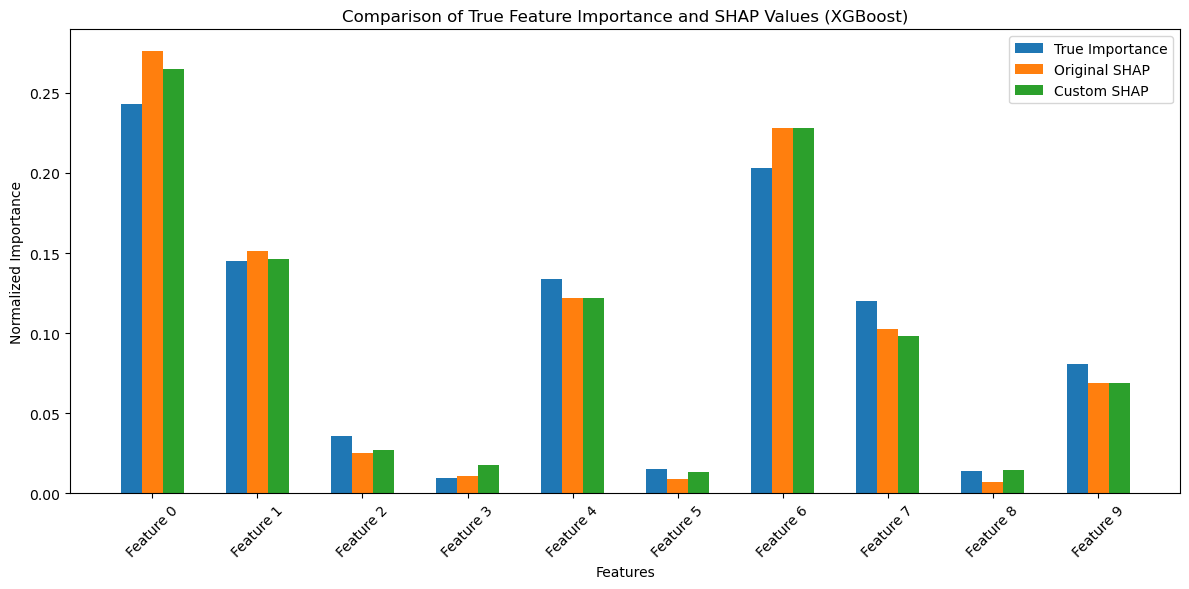

In [6]:
# Plot comparison
plt.figure(figsize=(12, 6))
bar_width = 0.2
index = np.arange(len(feature_names))

plt.bar(index, comparison_df['True Importance'], bar_width, label='True Importance')
plt.bar(index + bar_width, comparison_df['Original SHAP'], bar_width, label='Original SHAP')
plt.bar(index + 2*bar_width, comparison_df['Custom SHAP'], bar_width, label='Custom SHAP')

plt.xlabel('Features')
plt.ylabel('Normalized Importance')
plt.title('Comparison of True Feature Importance and SHAP Values (XGBoost)')
plt.xticks(index + bar_width, feature_names, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [7]:
# Correlation with true importances
corr_true_original, _ = pearsonr(true_importances, norm_mean_abs_shap_values)
corr_true_custom, _ = pearsonr(true_importances, norm_mean_abs_custom_shap_values)

print(f'Correlation between True Importances and Original SHAP (XGBoost): {corr_true_original:.4f}')
print(f'Correlation between True Importances and Custom SHAP (XGBoost): {corr_true_custom:.4f}')

Correlation between True Importances and Original SHAP (XGBoost): 0.9919
Correlation between True Importances and Custom SHAP (XGBoost): 0.9892


#### Simulate Sequential Data and Train LSTM Model

In [8]:
# Simulate sequential data
sequential_simulator = SequentialDataSimulator(n_samples=1000, timesteps=10, features=1)
X_seq, y_seq = sequential_simulator.get_data()
true_influences = sequential_simulator.get_true_importances()

# Ensure correct shape
if len(X_seq.shape) != 3:
    X_seq = X_seq.reshape((X_seq.shape[0], sequential_simulator.timesteps, sequential_simulator.features))

# Split data
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(X_seq, y_seq, test_size=0.2)

# Build and train LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(50, input_shape=(sequential_simulator.timesteps, sequential_simulator.features)))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')

# Train model
model_lstm.fit(X_train_seq, y_train_seq, epochs=10, batch_size=32, verbose=1)


Epoch 1/10


/home/niyang/miniconda3/envs/shap/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 13.7825
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 13.7869
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.9882 
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.0352
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.1631
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.1111
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.7554
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.7253
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.7842
Epoch 10/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.2031


In [9]:
# Sample data for SHAP computations
X_train_sample_seq = X_train_seq[:100]
X_test_sample_seq = X_test_seq[:10]

# Compute SHAP values using GradientExplainer
explainer_shap_seq = shap.GradientExplainer(model_lstm, X_train_sample_seq)
shap_values_shap_seq = explainer_shap_seq.shap_values(X_test_sample_seq)

/home/niyang/miniconda3/envs/shap/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: keras_tensor. Received: the structure of inputs=['*']
  warnings.warn(


In [10]:
# Initialize custom SHAP approximator
custom_shap_approximator_seq = SequentialSHAPApproximator(model_lstm, X_train_sample_seq, num_samples=100)

# Compute SHAP values using custom approximator
shap_values_custom_seq = custom_shap_approximator_seq.compute_shap_values(X_test_sample_seq)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━

In [11]:
# Compute mean absolute SHAP values for the original SHAP values
mean_abs_shap_values_seq = np.mean(np.abs(shap_values_shap_seq), axis=0).flatten()
# Compute mean absolute SHAP values for the custom SHAP values
mean_abs_custom_shap_values_seq = np.mean(np.abs(shap_values_custom_seq), axis=0).flatten()

# Normalize SHAP values
norm_mean_abs_shap_values_seq = mean_abs_shap_values_seq / np.sum(mean_abs_shap_values_seq)
norm_mean_abs_custom_shap_values_seq = mean_abs_custom_shap_values_seq / np.sum(mean_abs_custom_shap_values_seq)

# Create DataFrame for comparison
time_steps = np.arange(len(true_influences))
comparison_seq_df = pd.DataFrame({
    'Time Step': time_steps,
    'True Influence': true_influences,
    'Original SHAP': norm_mean_abs_shap_values_seq,
    'Custom SHAP': norm_mean_abs_custom_shap_values_seq
})

print(comparison_seq_df)


   Time Step  True Influence  Original SHAP  Custom SHAP
0          0        0.189320       0.242498     0.232689
1          1        0.242523       0.183240     0.175241
2          2        0.028231       0.102008     0.099528
3          3        0.001667       0.012835     0.020918
4          4        0.170333       0.074849     0.077551
5          5        0.081156       0.137966     0.145634
6          6        0.021422       0.087636     0.087213
7          7        0.044542       0.073064     0.075413
8          8        0.078823       0.016085     0.018256
9          9        0.141984       0.069819     0.067557


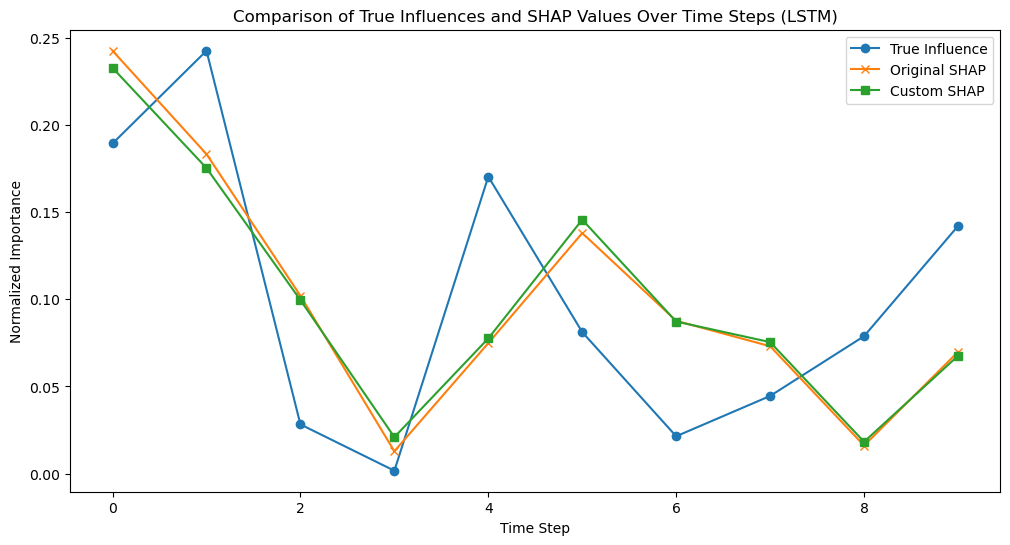

In [12]:
# Plot comparison over time steps
plt.figure(figsize=(12, 6))
plt.plot(comparison_seq_df['Time Step'], comparison_seq_df['True Influence'], marker='o', label='True Influence')
plt.plot(comparison_seq_df['Time Step'], comparison_seq_df['Original SHAP'], marker='x', label='Original SHAP')
plt.plot(comparison_seq_df['Time Step'], comparison_seq_df['Custom SHAP'], marker='s', label='Custom SHAP')
plt.xlabel('Time Step')
plt.ylabel('Normalized Importance')
plt.title('Comparison of True Influences and SHAP Values Over Time Steps (LSTM)')
plt.legend()
plt.show()

In [13]:
# Correlation with true influences
corr_true_original_seq, _ = pearsonr(true_influences, norm_mean_abs_shap_values_seq)
corr_true_custom_seq, _ = pearsonr(true_influences, norm_mean_abs_custom_shap_values_seq)

print(f'Correlation between True Influences and Original SHAP (LSTM): {corr_true_original_seq:.4f}')
print(f'Correlation between True Influences and Custom SHAP (LSTM): {corr_true_custom_seq:.4f}')

Correlation between True Influences and Original SHAP (LSTM): 0.6403
Correlation between True Influences and Custom SHAP (LSTM): 0.6223
